#### Importing packages 

In [1]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import os, shutil
from glob import glob

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


#### Code to create DataFrames to map path to images with labels 

In [2]:
# creating dataframe with the path and image id 

train_origin_dir = '/home/knajf/train'
test_origin_dir = '/home/knajf/datasets/cancer/test'
df = pd.DataFrame({'path': glob(os.path.join(train_origin_dir,'*.tif'))})

# accessing the id of the image 
df['id'] = df.path.map(
    lambda x: x.split('/')[-1].split('.')[0]
)

# importing the labels and merging on 'id' column 
label_path = os.path.join('/home/knajf/datasets/cancer', 'train_labels.csv')
df_labels = pd.read_csv(filepath_or_buffer = label_path)
df = df.merge(df_labels, on = 'id')

In [3]:
df.head()

,path,id,label
0,/home/knajf/train/3297847a5ddca221a06b8562e7ca...,3297847a5ddca221a06b8562e7ca9f72f683c48d,1
1,/home/knajf/train/c7ad5078e1a5fc2f653caf53beb3...,c7ad5078e1a5fc2f653caf53beb32dbbd42cd840,1
2,/home/knajf/train/d83605d3ea636c23cb60668e6068...,d83605d3ea636c23cb60668e6068bb7a8f130492,0
3,/home/knajf/train/48aea54e6e1e1c1d99605cafe1f0...,48aea54e6e1e1c1d99605cafe1f0f4326060599a,0
4,/home/knajf/train/8a5cf51ca7c1c39f8154e644240a...,8a5cf51ca7c1c39f8154e644240a45b5795920a6,0


#### Train-test split 

In [4]:
# train-val split 

df_train, df_val = train_test_split(df, test_size = 0.20, shuffle = True)

In [5]:
# santity check 

print(len(df_train))
print(len(df_val))

176020
44005


#### Code to run first time to create folders 

In [17]:
# creating dataset foler 

dataset_folder = os.path.join(os.getcwd(), 'datasets')
os.mkdir(dataset_folder)

In [18]:
# creating histopathologic folder 

hist_folder = os.path.join(dataset_folder, 'histopathologic')
os.mkdir(hist_folder)

In [19]:
base_dir = hist_folder

# creating training directory 
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

# creating validation directory 
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

# creating test directory 
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# creating binary class directories on training and validation paths 
train_val_paths = [train_dir, validation_dir]
for folder in train_val_paths: 
    for subfolder in ['0', '1']: 
        os.mkdir(os.path.join(folder, subfolder))

#### When data is in folders run this code to init paths 

In [6]:
# init paths
dataset_folder = os.path.join(os.getcwd(), 'datasets')
hist_folder = os.path.join(dataset_folder, 'histopathologic')
base_dir = hist_folder
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

#### Code to add data to designated folders 

In [25]:
# adding training set data to folders 

for entry in df_train['id']: 
    # get label 
    label = df_train.loc[df_train.id == entry].label.values[0]
    
    # add '.tif' to end 
    fname = entry + '.tif'
    
    # copy from source to input/train/label folder
    label_folder = os.path.join(train_dir, str(label))
    src = os.path.join(train_origin_dir, fname)
    dst = os.path.join(label_folder, fname)
    shutil.copyfile(src, dst)

In [26]:
# adding validation set data to folders

for entry in df_val['id']: 
    # get label 
    label = df_val.loc[df_val.id == entry].label.values[0]
    
    # add '.tif' to end 
    fname = entry + '.tif'
    
    # copy from source to input/train/label folder
    label_folder = os.path.join(validation_dir, str(label))
    src = os.path.join(train_origin_dir, fname)
    dst = os.path.join(label_folder, fname)
    shutil.copyfile(src, dst)

In [27]:
print('total training images labeled 0: ', len(os.listdir(os.path.join(train_dir, '0'))))
print('total training images labeled 1: ', len(os.listdir(os.path.join(train_dir, '1'))))
print('total validation images labeled 0: ', len(os.listdir(os.path.join(validation_dir, '0'))))
print('total validation images labeled 1: ', len(os.listdir(os.path.join(validation_dir, '1'))))
print('total number of images: ', len(os.listdir(os.path.join(train_dir, '0'))) + 
      len(os.listdir(os.path.join(train_dir, '1'))) + 
      len(os.listdir(os.path.join(validation_dir, '0'))) + 
      len(os.listdir(os.path.join(validation_dir, '1'))))

total training images labeled 0:  104715
total training images labeled 1:  71305
total validation images labeled 0:  26193
total validation images labeled 1:  17812
total number of images:  220025


#### Initialize ImageDataGenerator 

In [12]:
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 96 # nbr of pixels 
num_train_samples = len(df_train) # nbr of samples to train on
num_val_samples = len(df_val) # nbr of samples to perform validation on 
train_batch_size = 32 # number of samples to train on per epoch
val_batch_size = 32 # number of samples to validate on per epoch  

train_steps = np.ceil(num_train_samples / train_batch_size) # number of gradient descent steps per epoch
val_steps = np.ceil(num_val_samples / val_batch_size) 

train_datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x)
test_datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = train_batch_size, 
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = val_batch_size,
        class_mode = 'binary'
)

Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.


In [13]:
from keras import layers 
from keras import models 

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', 
                        input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = 'sigmoid'))

    

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 128)       73856     
__________

In [14]:
from keras import optimizers

callback_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'acc',
        patience = 5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = 'my_model.h5',
        monitor = 'val_loss',
        save_best_only = True,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.5, 
        patience = 2,
        min_lr=0.00001
    )
]
model.compile(loss = 'binary_crossentropy', 
             optimizer = optimizers.Adam(lr = 0.0001),
             metrics = ['acc'])

In [15]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = train_steps, 
    epochs = 15, 
    validation_data = validation_generator, 
    validation_steps = val_steps,
    callbacks = callback_list,
)

Epoch 1/15
5501/5501 [==============================] - 6458s 1s/step - loss: 0.4390 - acc: 0.7958 - val_loss: 0.5005 - val_acc: 0.7589
Epoch 2/15
5501/5501 [==============================] - 1338s 243ms/step - loss: 0.3677 - acc: 0.8361 - val_loss: 0.3925 - val_acc: 0.8177
Epoch 3/15
   4/5501 [..............................] - ETA: 9:00 - loss: 0.3021 - acc: 0.8594 

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100976). Check your callbacks.
  % delta_t_median)


5501/5501 [==============================] - 1337s 243ms/step - loss: 0.3137 - acc: 0.8650 - val_loss: 0.3007 - val_acc: 0.8720
Epoch 4/15
5501/5501 [==============================] - 1331s 242ms/step - loss: 0.2780 - acc: 0.8831 - val_loss: 0.2484 - val_acc: 0.9014
Epoch 5/15
5501/5501 [==============================] - 1336s 243ms/step - loss: 0.2541 - acc: 0.8958 - val_loss: 0.2587 - val_acc: 0.8977
Epoch 6/15
   4/5501 [..............................] - ETA: 6:57 - loss: 0.2116 - acc: 0.9062

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102048). Check your callbacks.
  % delta_t_median)


5501/5501 [==============================] - 1330s 242ms/step - loss: 0.2341 - acc: 0.9050 - val_loss: 0.2174 - val_acc: 0.9126
Epoch 7/15
5501/5501 [==============================] - 1335s 243ms/step - loss: 0.2190 - acc: 0.9119 - val_loss: 0.2050 - val_acc: 0.9206
Epoch 8/15
5501/5501 [==============================] - 1331s 242ms/step - loss: 0.2057 - acc: 0.9176 - val_loss: 0.1949 - val_acc: 0.9245
Epoch 9/15
5501/5501 [==============================] - 1330s 242ms/step - loss: 0.1945 - acc: 0.9226 - val_loss: 0.1949 - val_acc: 0.9236
Epoch 10/15
5501/5501 [==============================] - 1339s 243ms/step - loss: 0.1844 - acc: 0.9272 - val_loss: 0.1829 - val_acc: 0.9293
Epoch 11/15
5501/5501 [==============================] - 1334s 242ms/step - loss: 0.1749 - acc: 0.9316 - val_loss: 0.1928 - val_acc: 0.9253
Epoch 12/15
5501/5501 [==============================] - 1326s 241ms/step - loss: 0.1663 - acc: 0.9349 - val_loss: 0.1732 - val_acc: 0.9331
Epoch 13/15
5501/5501 [============

#### Saving the model 

In [16]:
model.save('model-5.h5')

#### Plotting training and validation accuracy and loss 

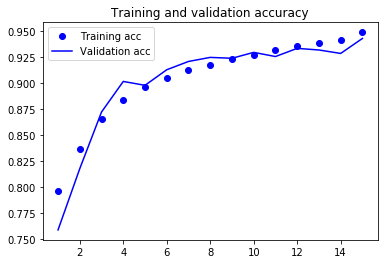

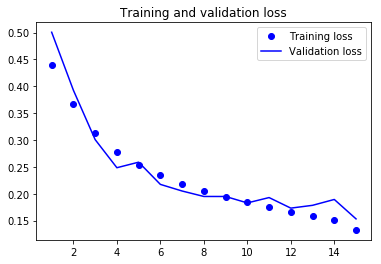

In [17]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Loading model 

In [48]:
from keras.models import load_model

model = load_model('my_model.h5')

#### Predict on validation data 

In [26]:
# predict on validation data - create new data generator that points to validation directory 

test_gen = test_datagen.flow_from_directory(
    validation_dir, 
    target_size  = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = 1,
    class_mode = 'binary',
    shuffle = False

)

predictions = model.predict_generator(test_gen, steps = len(df_val), verbose = 1)

Found 44005 images belonging to 2 classes.


#### Validation using ROC AUC and precision & recall 

1. __Precision__
_calculates the accuracy of the positive predictions of the classifier and is defined as_ 

$$\frac{TP}{TP + FP}$$

2. __Recall__
_the sensitivity (true positive rate) of the classifier and is defined as_

$$\frac{TP}{TP + FN}$$

3. The harmonic mean of precision and recall is called the F1-score and it is defined as

$$ 2* \frac{precision * recall}{precision + recall}$$

4. The ROC curve 

_Reciever operating characteristic (ROC) plots the true positive rate (recall) against false positive rate i.e. the ratio of negative instances that are incorrectly classified as positive. Equal to 1 - true negative rate which is the ratio of negative instances correctly classified as negative_

5. AUC ROC 

_The area under the ROC curve_

#### AUC ROC evaluation 

In [26]:
# get the true classes 

true_targets = test_gen.classes

In [27]:
from sklearn.metrics import roc_auc_score

roc_auc_score(true_targets, predictions)

0.9698984620108524

In [28]:
# classification report 

pred_binary = np.round(predictions)

from sklearn.metrics import classification_report

report = classification_report(true_targets, pred_binary)

print(report)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     26193
           1       0.91      0.88      0.89     17812

   micro avg       0.92      0.92      0.92     44005
   macro avg       0.91      0.91      0.91     44005
weighted avg       0.92      0.92      0.92     44005



#### Making kaggle submission 

In [21]:
# predict on test data 
test_set_dir = '/home/knajf/test/'

test_data_generator = test_datagen.flow_from_directory(
        test_set_dir,
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False 
)



Found 57458 images belonging to 1 classes.


In [19]:
# load weights from best epoch 

model.load_weights('model-5.h5')

In [22]:
test_predictions = model.predict_generator(test_data_generator, steps = 57458, verbose = 1)

57458/57458 [==============================] - 4929s 86ms/step


In [23]:
filenames = test_data_generator.filenames

id = [fname.split('/')[-1].split('.')[0] for fname in filenames]

submission_df = pd.DataFrame({'id':id, 
                           'label':test_predictions.reshape(-1), 
                          }).set_index('id')


In [24]:
submission_df.to_csv('histo-cancer-sub-v5.csv', columns=['label']) 

In [25]:
# get current path

print(os.getcwd())

/home/jupyter
